In [1]:
using Random
using PyPlot

┌ Info: Recompiling stale cache file /Users/davidbuchaca1/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


# Basics of random number generation

In [2]:
uniform_sample_in_zero_maxval(n_features, maxval) = maxval .* (1 .- rand(n_features)) 

uniform_sample_in_minval_maxval(n_features, minval, maxval) = (maxval-minval) .* rand(n_features) .+ minval 

# x=rand() is a sample from N(0,1) =>  x2 = mu + sqrt(std)*rand() is a sample from  N(mu, std)
normal_sample(n_features, mu, var) = mu .+ sqrt(var) .* randn(n_features)

normal_sample (generic function with 1 method)

In [3]:
maxval = 10
n_features = 2
uniform_sample_in_zero_maxval(n_features, maxval)

2-element Array{Float64,1}:
 3.4150558588551116
 2.9451189077022466

In [4]:
maxval = 3
uniform_sample_in_zero_maxval(n_features, maxval)

2-element Array{Float64,1}:
 0.2295173594460167
 1.2587911446353377

In [5]:
minval = 2
maxval = 10

uniform_sample_in_minval_maxval(n_features ,minval, maxval)

2-element Array{Float64,1}:
 3.6317041441121347
 5.603982582394908 

# Blob generator

In [369]:
using BenchmarkTools



In [370]:
# make blobs

"""
    make_blobs(n_examples=100; 
               n_features=2, 
               centers=3, 
               cluster_std=1.0, 
               center_box=(-10.,10.),
               element_type=Float64,
               random_seed=1234,
               return_centers=false)
               
     Generates a dataset with `n_examples` of dimension `n_features` and returns a vector containing
     as integers the membership of the different points generated.

     The data is roughly grouped around several `centers`  which are created using `cluster_std`. 
     The data lives inside `center_box` in the case it is randomly generated.
     
     - If `centers` is an integer the centroids are created randomly.    
     - If `centers` is an Array containing points the centroids are picked from `centers`.
     - If `return_centers=true` the centroids of the bloods are returned

"""
function make_blobs(n_examples=100; n_features=2, 
                    centers=3, cluster_std=1.0, center_box=(-10.,10.),
                    element_type=Float64, random_seed=1234, return_centers=false)

    Random.seed!(random_seed)

    X = [] 
    y = []

    if typeof(centers)<: Int
        n_centers = centers
        centers = []
        for c in 1:n_centers
            center_sample = uniform_sample_in_minval_maxval(n_features, center_box[1], center_box[2])
            push!(centers, center_sample)
        end
    else
        n_centers = length(centers)
    end

    if typeof(cluster_std)<: AbstractFloat
        cluster_std = 0.5 * randn(n_centers)
    end
    
    # generates the nunber of example for each center
    n_examples_per_center = [div(n_examples, n_centers) for x  in 1:n_centers]
    for i in 1:(n_examples % n_centers)
        n_examples_per_center[i] += 1
    end

    # generates the actual vectors close to each center blob 
    for (i, (n, std, center)) in enumerate(zip(n_examples_per_center, cluster_std, centers))
        X_current = center' .+ std .* randn(element_type, (n, n_features))
        push!(X, X_current)
        push!(y, [i for k in 1:n]) 
    end

    # stack all the previous arrays created for each of the centers
    X = cat(X..., dims=1)
    y = cat(y..., dims=1)
    
    if return_centers
        return X, y, centers  
    else
        return X, y
    end
end

make_blobs

In [371]:
@btime X, y, c = make_blobs(100; centers=3, random_seed=7, return_centers=true)


  42.991 μs (209 allocations: 14.72 KiB)


([6.33292 3.16605; 6.28889 3.12579; … ; 0.75025 -4.07654; -0.481265 -5.60262], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], Any[[6.24877, 3.09955], [-0.207732, -8.42481], [1.63181, -4.83893]])

In [8]:
c

3-element Array{Any,1}:
 [6.24877, 3.09955]   
 [-0.207732, -8.42481]
 [1.63181, -4.83893]  

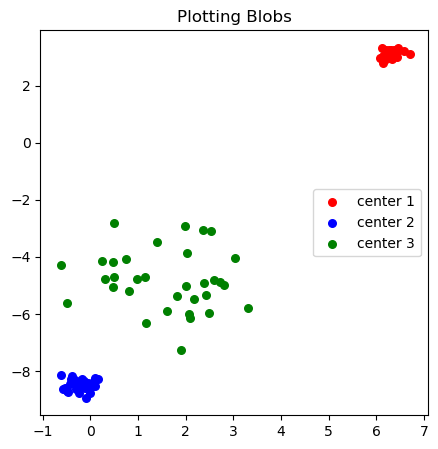

PyObject <matplotlib.legend.Legend object at 0x7f98e1200c88>

In [11]:

X1 = X[y.==1,:]
X2 = X[y.==2,:]
X3 = X[y.==3,:]

fig = figure(figsize=(5,5))
title("Plotting Blobs")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "center 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "center 2", s = 30)
B = scatter(X3[:,1],X3[:,2],color="green", label = "center 3", s = 30)
legend(loc="right")
#savefig("blobs.pdf")  

In [293]:
function shuffle_Xy(X, y; random_seed=1234)
    Random.seed!(random_seed)
    perm = randperm(length(y))
    return X[perm,:], y[perm]
end

shuffle_Xy (generic function with 1 method)

In [338]:
n_per_center
k=3
print("$(n_per_center[k])")

34

In [362]:
function make_blobs2(n::Int=100; p::Int=2,
                    shuffle::Bool=false, centers=3, cluster_std::Real=1.0, center_box=(-10.,10.),
                    element_type=Float64, random_seed=1234, return_centers=false, verbose=0)

    Random.seed!(random_seed)

    X = []
    y = []

    if typeof(centers) <: Int
        n_centers = centers
        centers = []
        for c in 1:n_centers
            center_sample = uniform_sample_in_minval_maxval(p, center_box[1], center_box[2])
            push!(centers, center_sample)
        end
    else
        n_centers = length(centers)
    end

    if typeof(cluster_std) <: AbstractFloat
        cluster_std = cluster_std * randn(n_centers)
    end

    # generates div(n, n_centers) examples assigned to each center
    n_per_center = [div(n, n_centers) for x  in 1:n_centers]

    # adds the reamainding examples to each center up to n
    n_per_center = fill(div(n,n_centers), n_centers)
    n_per_center[end] += rem(n,n_centers)

    # generates the actual vectors close to each center blob
    X = zeros(n, p)
    y = zeros(n)

    start_ind = 1
    for (i, (n_blob, std, center)) in enumerate(zip(n_per_center, cluster_std, centers))
        ind_center = start_ind:(start_ind + n_per_center[i]-1)
        X[ind_center,:] .= center' .+ std .* randn(element_type, (n_per_center[i], p));
        y[ind_center] .= i
        if verbose>0
            println("center $i with $(n_per_center[i]) points created")
        end
        start_ind += n_per_center[i]
    end

    if shuffle
       X, y = shuffle_Xy(X, y ; random_seed=random_seed)
    end

    if return_centers
        return X, y, centers
    else
        return X, y
    end
end

make_blobs2 (generic function with 2 methods)

In [367]:
@btime X, y= make_blobs2(100; centers=3, random_seed=5, return_centers=false)

┌ Info: Recompiling stale cache file /Users/davidbuchaca1/.julia/compiled/v1.1/BenchmarkTools/ZXPQo.ji for BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1184
┌ Warning: Module JSON with build ID 34420740956980 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947


  25.059 μs (113 allocations: 8.67 KiB)


([0.37752 4.45575; -0.188931 4.76348; … ; 6.739 0.612116; 6.82295 0.504707], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0])

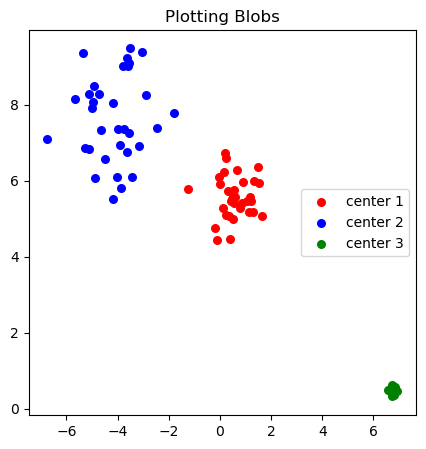

PyObject <matplotlib.legend.Legend object at 0x7f993124c1d0>

In [361]:

X1 = X[y.==1,:]
X2 = X[y.==2,:]
X3 = X[y.==3,:]

fig = figure(figsize=(5,5))
title("Plotting Blobs")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "center 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "center 2", s = 30)
B = scatter(X3[:,1],X3[:,2],color="green", label = "center 3", s = 30)
legend(loc="right")
#savefig("blobs.pdf")  

In [277]:
centers = 3
p=2
center_box=(-10.,10.)

(-10.0, 10.0)

In [278]:
if typeof(centers) <: Int
        n_centers = centers
        centers = []
        for c in 1:n_centers
            center_sample = uniform_sample_in_minval_maxval(p, center_box[1], center_box[2])
            push!(centers, center_sample)
        end
    else
        n_centers = length(centers)
    end

In [267]:
centers

3-element Array{Any,1}:
 [-7.83917, -5.63958]
 [-1.07545, 1.06716] 
 [5.49544, -8.63184] 

In [270]:
centers[1]

2-element Array{Float64,1}:
 -7.839172088318724
 -5.639578002860195

In [272]:
ind_center = 1:n_per_center[1]

1:33

In [275]:
X  = zeros(n, p)
X[ind_center,:] .= centers[1] .+ 0.3 

33×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮       
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

In [223]:
X = zeros(n,p);

In [224]:
i = 1
p = 1
print(length(p:p+n_per_center[i]-1), "    ", i, "   ",p:p+n_per_center[i]-1)
p += n_per_center[i];

33    1   1:33

In [225]:
i = 2
print(length(p:p+n_per_center[i]-1), "    ", i, "   ",p:p+n_per_center[i]-1)
p += n_per_center[i];

33    2   34:66

In [226]:
i = 3
print(length(p:p+n_per_center[i]-1), "    ", i, "   ",p:p+n_per_center[i]-1)
p += n_per_center[i];

34    3   67:100

In [229]:
X = zeros(100,2);

In [231]:
X[1:20,:] = randn(Float64, (20, 2));

# Circles generator

Make a circle containing another circle in 2d (mmake a ring with a ball inside).




In [74]:
"""
    Return evenly spaced numbers over a specified interval.
    
    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].
    
    The endpoint of the interval can optionally be excluded.

"""
function linspace(start, stop; num=50, endpoint=true, retstep=false)
    dif  = stop-start
    step = dif/num
    result = []
       
    if endpoint 
        for i in 1:num
            push!(result, start+i*step)
        end
    else
        for i in 1:num
            push!(result, start+(i-1)*step)
        end
    end
    return result
    
end

linspace

In [75]:
"""
Shuffles the rows of an Array `X` and the values of a vector `y` using a randomly
generated permutation. The same permutation is used to shuffle both `X` and `y`.
"""
function shuffle_Xy(X, y; random_seed=1234)
    Random.seed!(random_seed)
    perm = randperm(length(y))
    return X[perm,:], y[perm]
end


"""
    make_circles(n=100; shuffle=true, noise=0., random_seed=1234, factor=0.8)
    
    Generates a dataset with `n` bi-dimensional examples. Samples are created 
    from two circles. One of the circles inside the other. The `noise` scalar
    can be used to add noise to the generation process. The scalar `factor` 
    can be used to make the radious of the smallest circle smaller.

"""
function make_circles(n=100; shuffle=true, noise=0., random_seed=1234, factor=0.8)
    
    @assert 0 <= factor <=1  #factor in [0,1] 

    n_out = div(n, 2)
    n_in = n - n_out
     
    linspace_out = linspace(0, 2 * pi; num=n_out, endpoint=false)
    linspace_in  = linspace(0, 2 * pi; num=n_in, endpoint=false)

    outer_circ_x = cos.(linspace_out)
    outer_circ_y = sin.(linspace_out)
    inner_circ_x = cos.(linspace_in) .* factor
    inner_circ_y = sin.(linspace_in) .* factor
    
    X = [[outer_circ_x..., inner_circ_x...] [outer_circ_y..., inner_circ_y...]]
    y = [ones(Int,n_out)..., 2*ones(Int,n_in)...]

    if shuffle
       X, y = shuffle_Xy(X, y ; random_seed=random_seed)
    end
    
    if noise >0.
        X .= X .+ noise.* rand(size(X)...)
    end

    return X,y
end

make_circles

In [76]:
n_out = 10
linspace(0, 2 * pi; num=n_out, endpoint=false)

10-element Array{Any,1}:
 0.0               
 0.6283185307179586
 1.2566370614359172
 1.8849555921538759
 2.5132741228718345
 3.141592653589793 
 3.7699111843077517
 4.39822971502571  
 5.026548245743669 
 5.654866776461628 

In [77]:
?fill

search: fill fill! fill_between fill_betweenx finally findall get_figlabels



2-element Array{Any,1}:
 ```
fill(x, dims)
```

Create an array filled with the value `x`. For example, `fill(1.0, (5,5))` returns a 5×5 array of floats, with each element initialized to `1.0`.

# Examples

```jldoctest
julia> fill(1.0, (5,5))
5×5 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
```

If `x` is an object reference, all elements will refer to the same object. `fill(Foo(), dims)` will return an array filled with the result of evaluating `Foo()` once.
                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [46]:
?LinRange

search: LinRange



```
LinRange{T}
```

A range with `len` linearly spaced elements between its `start` and `stop`. The size of the spacing is controlled by `len`, which must be an `Int`.

# Examples

```jldoctest
julia> LinRange(1.5, 5.5, 9)
9-element LinRange{Float64}:
 1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5
```


In [53]:
#range(0,2*pi,10)

In [54]:
#?range

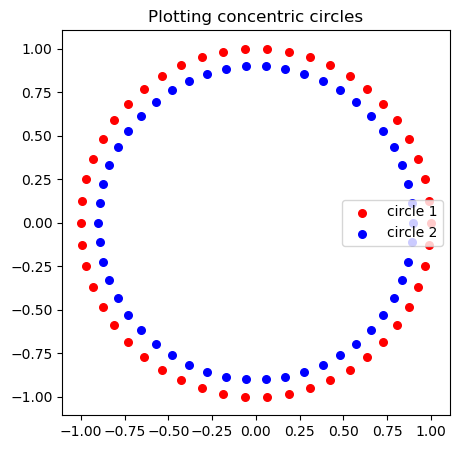

PyObject <matplotlib.legend.Legend object at 0x13f290ac8>

In [96]:
X,y = make_circles(100; factor=0.9);

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting concentric circles")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "circle 2", s = 30)
legend(loc="right")
#savefig("concentric_circles.pdf")  

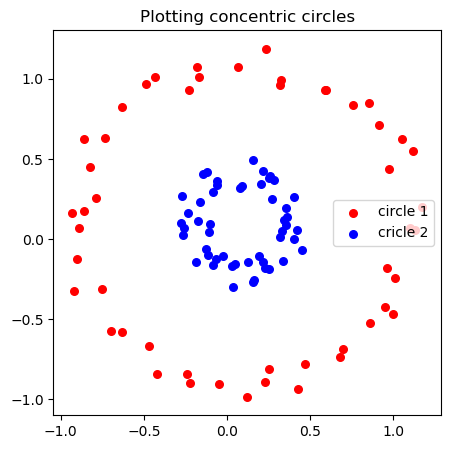

PyObject <matplotlib.legend.Legend object at 0x13f024eb8>

In [93]:
X,y = make_circles(100;noise=0.2, factor= 0.3);

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting concentric circles")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")
#savefig("concentric_circles.pdf")  

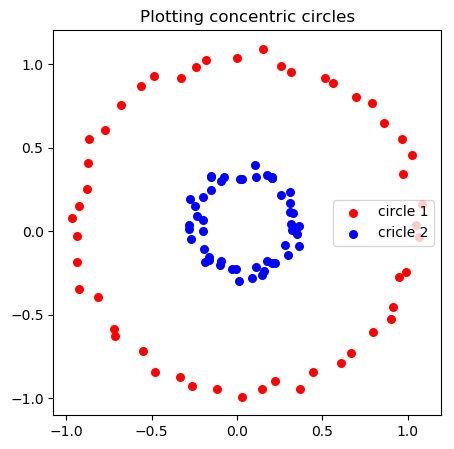

PyObject <matplotlib.legend.Legend object at 0x13ef0cf60>

In [92]:
X,y = make_circles(100;noise=0.1, factor=0.3);

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting concentric circles")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")
#savefig("concentric_circles.pdf")  

# Make moons

In [64]:
"""
    make_moons(n=100; shuffle=true, noise=0., translation=0.5, factor=1.0, random_seed=1234)
    
    Generates `n` examples sampling from two moons. The `noise` can be changed to add
    noise to the samples.

"""
function make_moons(n=100; shuffle=true, noise=0., translation=0.5, factor=1.0, random_seed=1234)
    
    @assert 0 <= factor <=1  

    n_out = div(n, 2)
    n_in = n - n_out
     
    linspace_out = linspace(0, pi; num=n_out, endpoint=true)
    linspace_in  = linspace(0, pi; num=n_in, endpoint=true)

    

    outer_circ_x = cos.(linspace_out)
    outer_circ_y = sin.(linspace_out)
    inner_circ_x = 1 .- cos.(linspace_in) .* factor
    inner_circ_y = 1 .- sin.(linspace_in) .* factor .- translation
    
    X = [[outer_circ_x..., inner_circ_x...] [outer_circ_y..., inner_circ_y...]]
    y = [ones(Int,n_out)..., 2*ones(Int,n_in)...]

    if shuffle
       X, y = shuffle_Xy(X, y ; random_seed=random_seed)
    end
    
    if noise >0.
        X .= X .+ noise.* rand(size(X)...)
    end

    return X,y
end

make_moons (generic function with 2 methods)

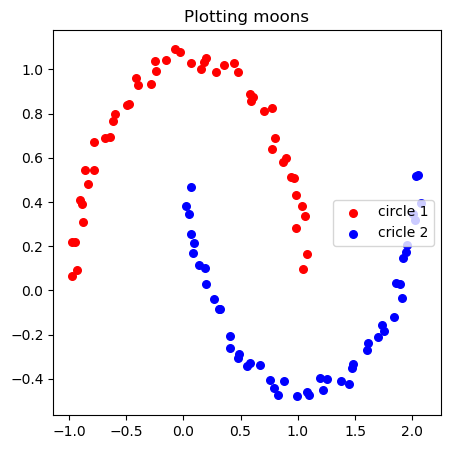

PyObject <matplotlib.legend.Legend object at 0x13d7435f8>

In [72]:
X,y = make_moons(100;noise=0.1);

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting moons")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")

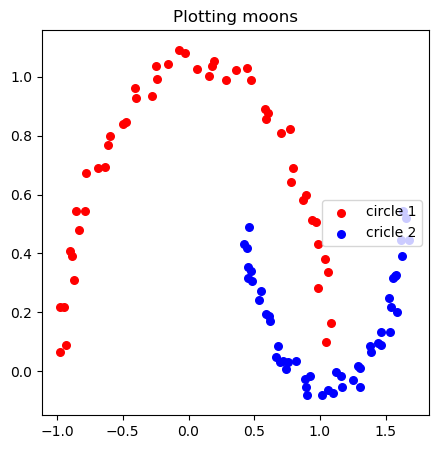

PyObject <matplotlib.legend.Legend object at 0x13df69550>

In [78]:
X,y = make_moons(100;noise=0.1, factor=0.6);


X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting moons")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")

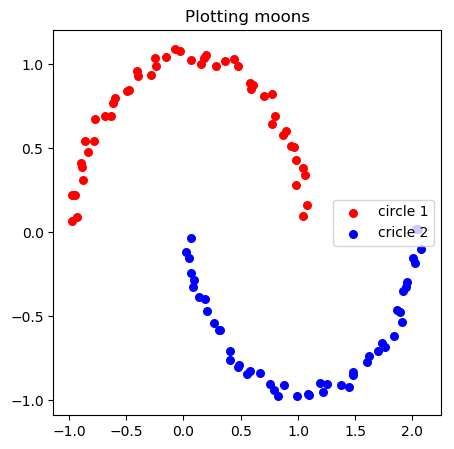

PyObject <matplotlib.legend.Legend object at 0x13e0c4940>

In [79]:
X,y = make_moons(100; noise=0.1, translation=1.0);

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting moons")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")

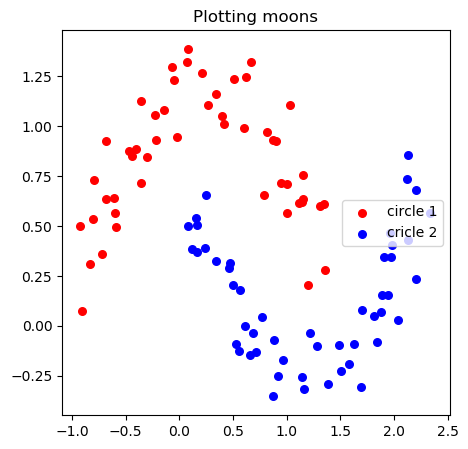

PyObject <matplotlib.legend.Legend object at 0x13e1eef28>

In [80]:
X,y = make_moons(100; noise=0.4, translation=0.4);

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting moons")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")

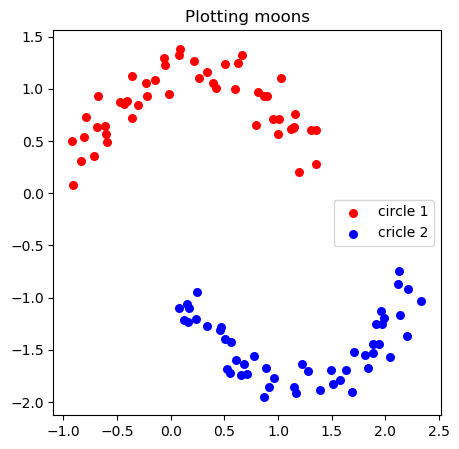

PyObject <matplotlib.legend.Legend object at 0x13e0b94e0>

In [82]:
X,y = make_moons(100; noise=0.4, translation=2.);

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting moons")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")